In [89]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime

import os
import pendulum
import scipy
import scikit_posthocs as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

# Load Statsmodels 
import statsmodels.api as sm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# Configure Pandas to display all columns and rows
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Load pricing data

In [91]:
df = pd.read_csv('data/df_pricing.csv')

In [92]:
df.head()

dates  geography_key  wholesaler_id_value state_code           city  \
0  2018-12-23          39774                 3142         NY      JAMESTOWN   
1  2018-12-23          39774                 3142         NY      JAMESTOWN   
2  2018-12-23        5446689                43100         NY  STATEN ISLAND   
3  2018-12-23         627036                 3142         NY      JAMESTOWN   
4  2018-12-23         147449                43100         NY       NEW YORK   

                            retailer_name        outlet_name  product_key  \
0            RITE AID - RITE AID PHARMACY               DRUG    210280222   
1            RITE AID - RITE AID PHARMACY               DRUG    210281267   
2        7 ELEVEN - SPEEDWAY SUPERAMERICA        CONVENIENCE    210283096   
3  7-ELEVEN - 7 ELEVEN/NORTH ATLANTIC DIV        CONVENIENCE    210280222   
4                          KMART - K MART  MASS MERCHANDISER    210283096   

  ab_category_style_value ab_wamp_value beer_style_value  \
0           CLASSIC LAGER          CORE   AMERICAN LAGER   
1           EASY DRINKING          CORE   AMERICAN LAGER   
2           CLASSIC LAGER         VALUE   AMERICAN LAGER   
3           CLASSIC LAGER          CORE   AMERICAN LAGER   
4           CLASSIC LAGER         VALUE   AMERICAN LAGER   

           brewer_value type_value  unit_sales  dollar_sales  volume_sales  \
0  ANHEUSER-BUSCH INBEV       BEER       15.00         29.85          1.30   
1  ANHEUSER-BUSCH INBEV       BEER       36.00         71.64          3.10   
2  ANHEUSER-BUSCH INBEV       BEER      296.00        298.32         25.70   
3  ANHEUSER-BUSCH INBEV       BEER       35.00         71.21          3.00   
4  ANHEUSER-BUSCH INBEV       BEER       85.00        126.65          7.40   

   year  month  day  week  season  holiday  product_price  \
0  2018     12   23    51  winter        0           1.99   
1  2018     12   23    51  winter        0           1.99   
2  2018     12   23    51  winter        0           1.01   
3  2018     12   23    51  winter        0           2.03   
4  2018     12   23    51  winter        0           1.49   

   relative_beer_style_price  
0                       0.98  
1                       0.98  
2                       0.49  
3                       1.00  
4                       0.73

## Explore data

In [93]:
df.shape

(16357, 24)

In [94]:
# Data types of the columns

df.dtypes

dates                         object
geography_key                  int64
wholesaler_id_value            int64
state_code                    object
city                          object
retailer_name                 object
outlet_name                   object
product_key                    int64
ab_category_style_value       object
ab_wamp_value                 object
beer_style_value              object
brewer_value                  object
type_value                    object
unit_sales                   float64
dollar_sales                 float64
volume_sales                 float64
year                           int64
month                          int64
day                            int64
week                           int64
season                        object
holiday                        int64
product_price                float64
relative_beer_style_price    float64
dtype: object

In [95]:
# conver the date col to datetime
df['dates'] = pd.to_datetime(df['dates'])

df.dtypes

dates                        datetime64[ns]
geography_key                         int64
wholesaler_id_value                   int64
state_code                           object
city                                 object
retailer_name                        object
outlet_name                          object
product_key                           int64
ab_category_style_value              object
ab_wamp_value                        object
beer_style_value                     object
brewer_value                         object
type_value                           object
unit_sales                          float64
dollar_sales                        float64
volume_sales                        float64
year                                  int64
month                                 int64
day                                   int64
week                                  int64
season                               object
holiday                               int64
product_price                   

In [96]:
unique_wholesalers = list(df.wholesaler_id_value.unique())
unique_products = list(df.product_key.unique())

In [97]:
no_sales_list = []

for w in unique_wholesalers:
    for p in unique_products:
        df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
        if df_small.shape[0]<53:
            no_sales_list.append((w, p))
            print(f'For wholesaler {w} & product {p} time series, there are {df_small.shape[0]} weeks in the data')

For wholesaler 43100 & product 262793636 time series, there are 0 weeks in the data
For wholesaler 43100 & product 609521221 time series, there are 0 weeks in the data
For wholesaler 43100 & product 1321133691 time series, there are 25 weeks in the data
For wholesaler 43168 & product 210280222 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210281267 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210283096 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210284670 time series, there are 0 weeks in the data
For wholesaler 43168 & product 210281273 time series, there are 0 weeks in the data
For wholesaler 83167 & product 210283096 time series, there are 36 weeks in the data
For wholesaler 34206 & product 210283096 time series, there are 0 weeks in the data
For wholesaler 34206 & product 210281273 time series, there are 0 weeks in the data
For wholesaler 44223 & product 210283096 time series, there are 1 weeks i

## Feature Engineering

In [98]:
conditions = [
    (df['year'] < 2020),
    (df['year']>= 2020) & (df['year']< 2022),
    (df['year']>= 2022)]

choices = ['Pre Covid', 'Covid', 'Post Covid']
df['Era'] = np.select(conditions, choices)


## Visualize data - EDA by Channel - Covid

### Channel - beer sales

- `By weeks over 5 years, across both wholesalers and 10 products`
- `By weeks over 5 years, for individual wholesalers across all products that each wholesaler sells`
- `By weeks over 5 years, for individual wholesalers and for individual 10 products`


In [104]:
def plot_channel_by_covid(
df: pd.DataFrame
):
    # overall
    df_grouped = df.groupby(['Era', 'outlet_name'])['dollar_sales'].mean().reset_index()
    fig = px.bar(df_grouped, x="Era", y="dollar_sales" , color = 'outlet_name',
             category_orders={"Era": ['pre-covid', 'covid', 'post-covid']},
             labels={'dollar_sales': 'Dollar Sales'},
             title='Average sales across 5 years (2018-23) for all wholesalers and 10 products')
    fig.show()
    
    # for each wholesaler across products
    for w in unique_wholesalers:
    
        df_grouped = df[df['wholesaler_id_value']== w].groupby(['Era', 'outlet_name'])['dollar_sales'].mean().reset_index()
        fig = px.bar(df_grouped, x="Era", y="dollar_sales" , color = 'outlet_name',
                     category_orders={"Era": ['pre-covid', 'covid', 'post-covid']},
                     labels={'dollar_sales': 'Dollar Sales'},
                     title=f'Average sales across 5 years (2018-23) for wholesaler {w} across all products that each wholesaler sells')
        fig.show()
    
    # for each wholesaler and for each product
    for w in unique_wholesalers[:2]:
        for p in unique_products[:2]:
            
            if (w, p) not in no_sales_list:
        
                df_grouped = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)].groupby(['Era', 'outlet_name'])['dollar_sales'].mean().reset_index()
                fig = px.bar(df_grouped, x="Era", y="dollar_sales" , color = 'outlet_name',
                             category_orders={"Era": ['pre-covid', 'covid', 'post-covid']},
                             labels={'dollar_sales': 'Dollar Sales'},
                             title=f'Average sales across 5 years (2018-23) for wholesaler {w} and product {p}')
                fig.show()


In [108]:
plot_channel_by_covid(df)

## Visualize data - EDA by Channel - Brewer

In [101]:
df['brewer'] = np.where(df['brewer_value'] == 'ANHEUSER-BUSCH INBEV', 'AB', 'Non-AB')

In [106]:
def plot_channel_by_brewer(
df: pd.DataFrame
):
    # overall
    df_grouped = df.groupby(['outlet_name', 'brewer'])['dollar_sales'].mean().reset_index()
    fig = px.bar(df_grouped, x="outlet_name", y="dollar_sales" , color = 'brewer',
             labels={'dollar_sales': 'Dollar Sales',
                     'outlet_name': 'Outlet Name'},
             title='Average sales across 5 years (2018-23) for all wholesalers and 10 products')
    fig.show()
    
    # for each wholesaler across products
    for w in unique_wholesalers:
    
        df_grouped = df[df['wholesaler_id_value']== w].groupby(['outlet_name', 'brewer'])['dollar_sales'].mean().reset_index()
        fig = px.bar(df_grouped, x="outlet_name", y="dollar_sales" , color = 'brewer',
                     labels={'dollar_sales': 'Dollar Sales',
                             'outlet_name': 'Outlet Name'},
                     title=f'Average sales across 5 years (2018-23) for wholesaler {w} across all products that each wholesaler sells')
        fig.show()
    
    # for each wholesaler and for each product
    for w in unique_wholesalers[:2]:
        for p in unique_products[:2]:
            if (w, p) not in no_sales_list:
        
                df_grouped = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)].groupby(['outlet_name', 'brewer'])['dollar_sales'].mean().reset_index()
                fig = px.bar(df_grouped, x="outlet_name", y="dollar_sales" , color = 'brewer',
                             labels={'dollar_sales': 'Dollar Sales',
                         'outlet_name': 'Outlet Name'},
                             title=f'Average sales across 5 years (2018-23) for wholesaler {w} and product {p}')
                fig.show()


In [109]:
plot_channel_by_brewer(df)

### Disclaimer - The plots are generated by the library, Plotly and they result in interactive plots. They would be visible when the cells are re-run on the respective computers. For the sake of ease, a few of those have been attached below as static images. 

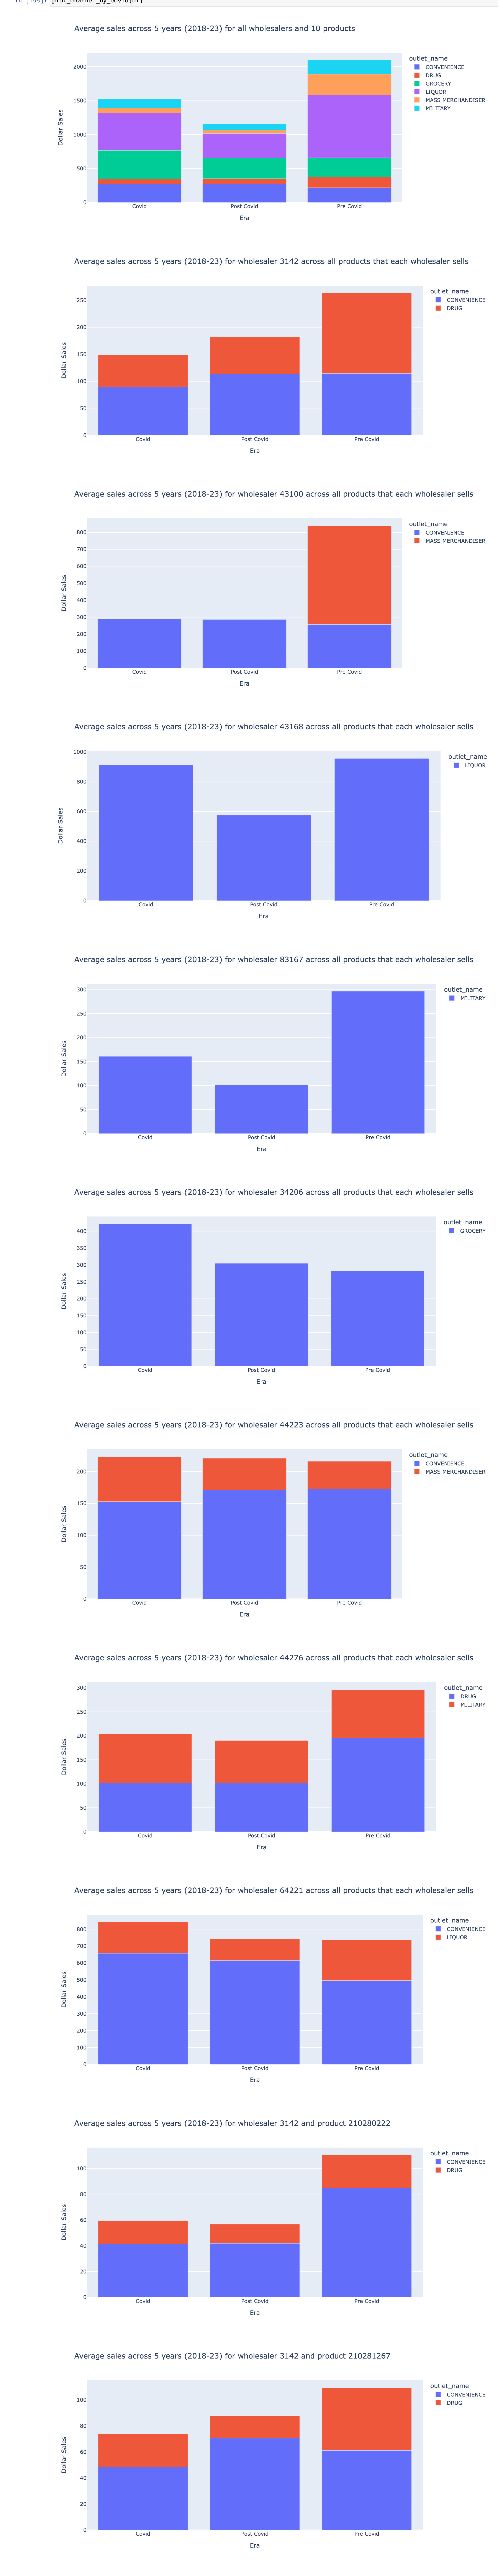

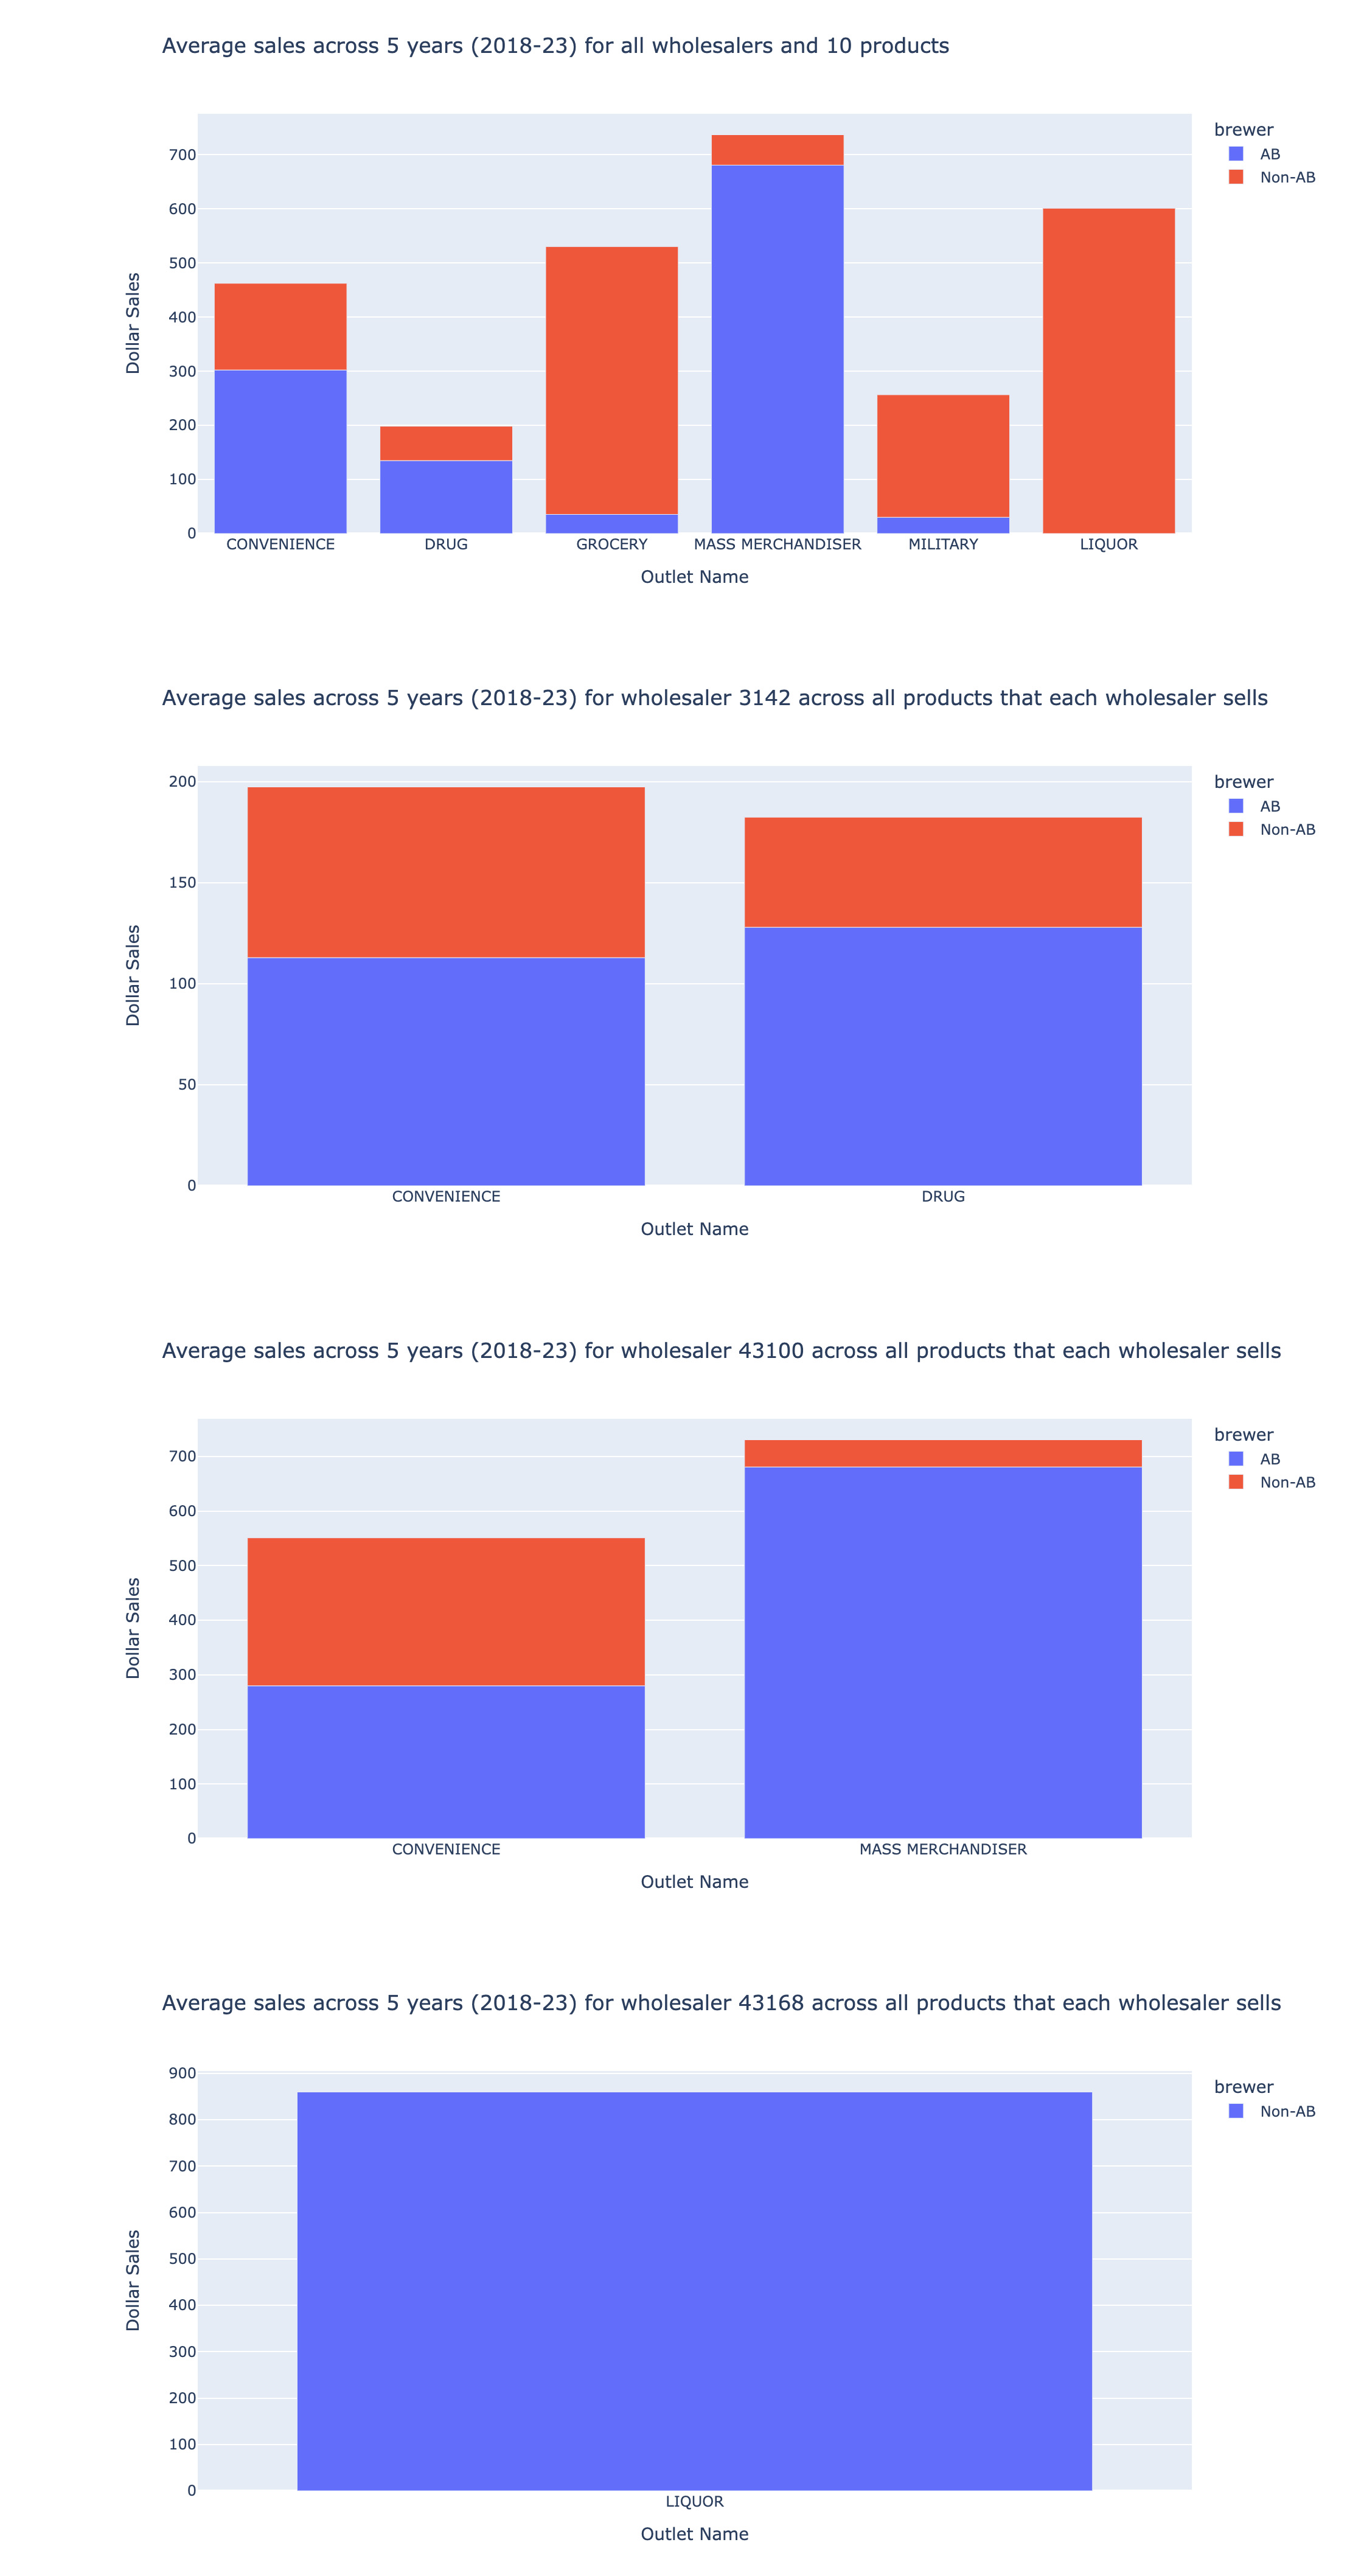

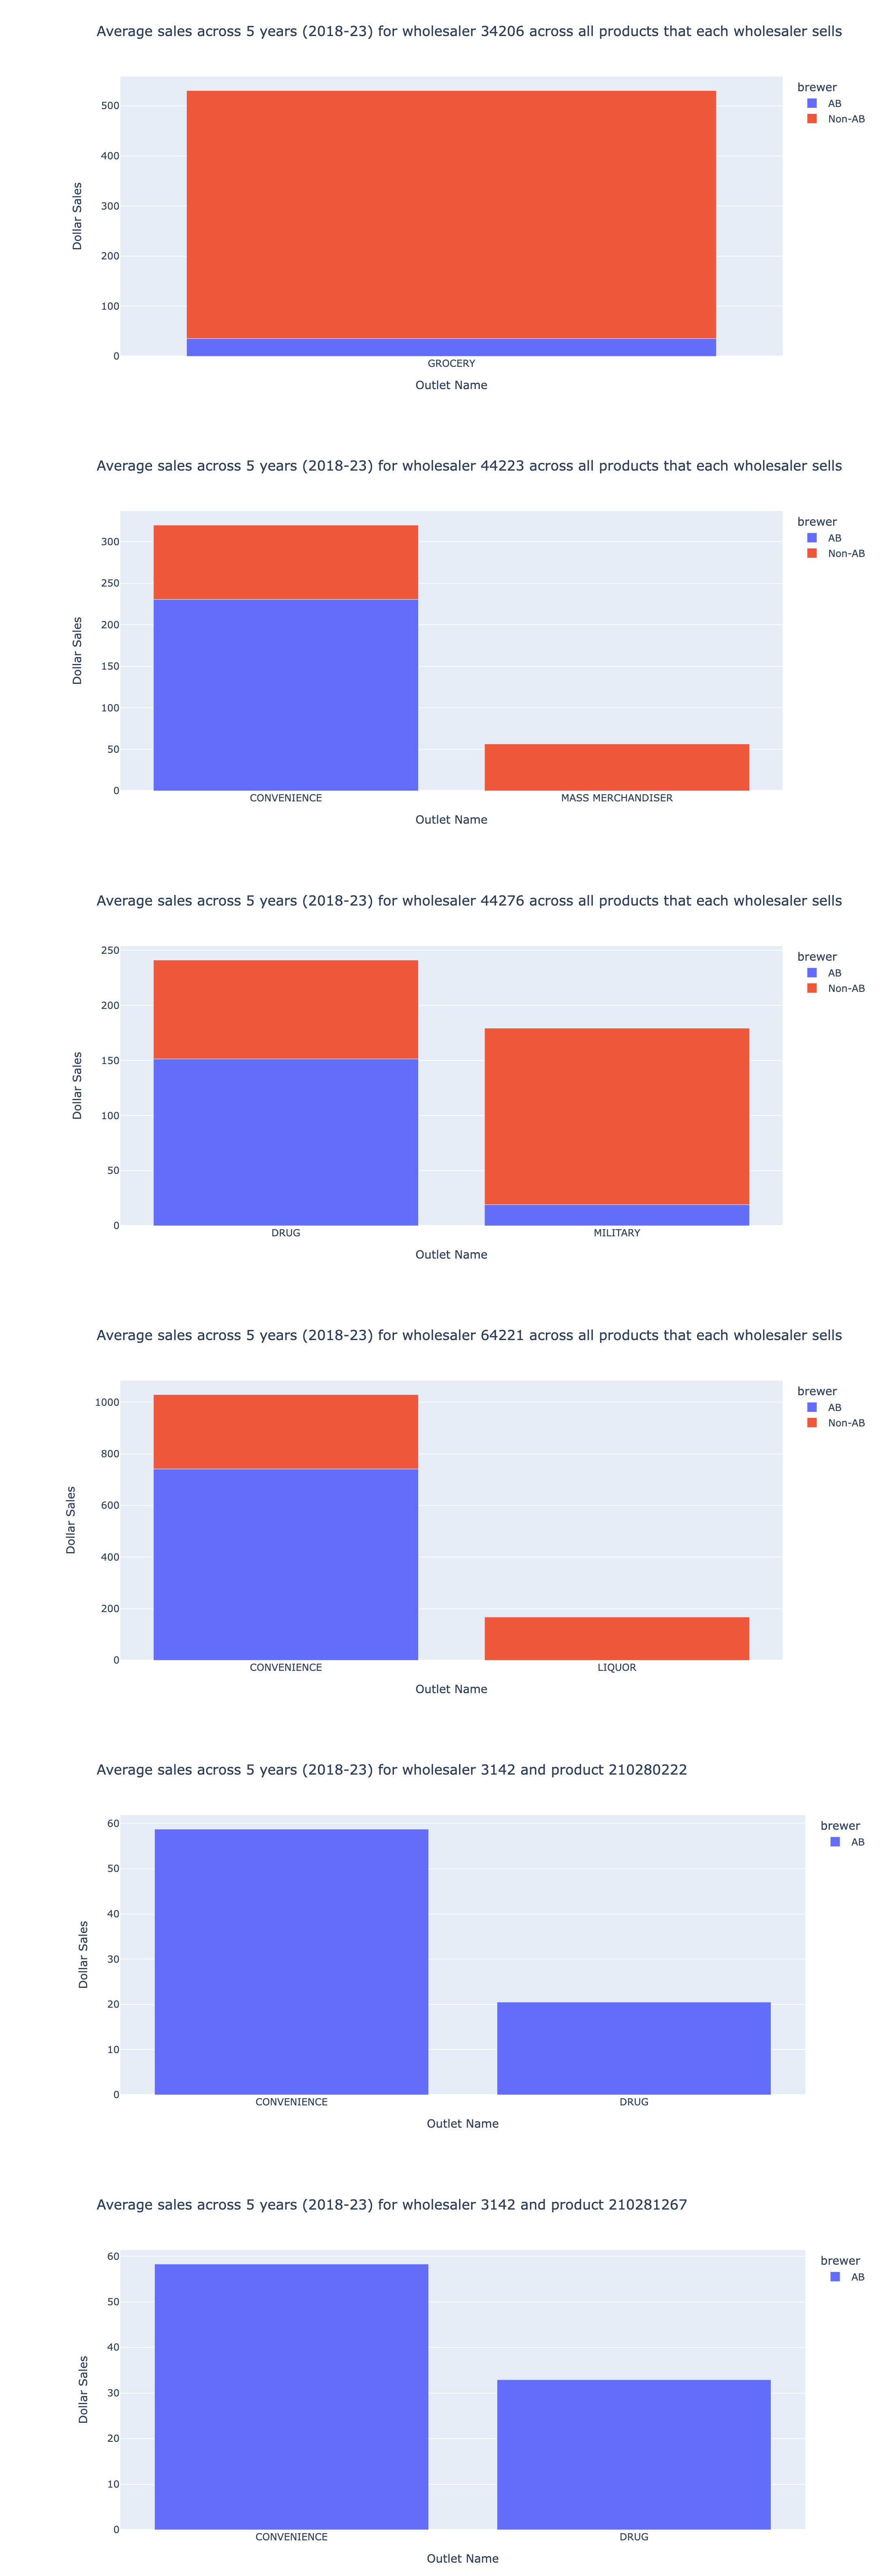

## Insights 

- **Overall, average beer sales for the sampled 10 (5 are AB brewed) products across 8 wholesalers over two states seem to have reduced from the pre-covid era to post-covid. The average overall sales based on this sample of data during covid is significantly higher than post-covid.**


- The average beer sales for convenience stores stayed mostly similar through the three eras – pre, during and post covid. Grocery store sales increased during covid and stayed similar pre and post-covid. Mass Merchandiser sales significantly reduced post-covid.


- Convenience stores have mostly similar average sales for AB brewed vs Non-AB brewed products, while grocery & liquor stores seem to be selling a lot more non-AB brewed products. Drug stores seem to be selling AB brewed products a lot more than non-AB.

## Save the final data

In [80]:
df_channel = df.copy()
df_channel.to_csv('data/df_final.csv', index=False)